### Data Loading

In [1]:
import pandas as pd
from helpers import *

Firstly, let's create our data-frame from our source data. Additionally, we'll transform the `Score_home` and `Score_away` columns into our target variable such that:
$$
y = \cases{-1 \\ 
            0 \\
            1 }
$$
using the helper function `score_to_win()`

In [2]:
DATA_SRC = '../Data/PL_site_2006_2018/masterdata.csv'
df = pd.read_csv(DATA_SRC)

# create win/lose label
df['target'] = df[['Score_home', 'Score_away']].apply(score_to_win, axis = 1)
df.head()

,MatchID,Home_team,Away_team,Score_home,Score_away,Possession_home,Possession_away,Shots_on_target_home,Shots_on_target_away,Shots_home,...,year,Expenditures_home,Arrivals_home,Income_home,Departures_home,Expenditures_away,Arrivals_away,Income_away,Departures_away,target
0,5937,Blackburn,Reading,3,3,54.0,46.0,6,4,15,...,2007,18.84,21,19.28,25,10.52,25,0.00,19,0
1,5938,Bolton,Aston Villa,2,2,47.1,52.9,2,2,11,...,2007,19.38,16,4.39,16,28.16,17,2.08,18,0
2,5939,Chelsea,Everton,1,1,59.3,40.7,7,6,20,...,2007,101.43,23,59.96,22,20.41,11,2.85,16,0
3,5940,Liverpool,Charlton,2,2,61.6,38.4,5,4,23,...,2007,52.44,27,23.94,28,24.68,31,2.59,36,0
4,5941,Man Utd,West Ham,0,1,65.3,34.7,7,2,30,...,2007,31.01,25,20.52,29,79.63,22,7.70,23,-1


### Feature Extraction
Now, we must drop several variables from the above table in order to fit our model. We'll create `df_wo` to pass in. This leaves us with 24 avaiable features.

In [3]:
df_wo = df.drop(columns = ['target', 'MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away', 'year'])
list(df_wo)

['Possession_home',
 'Possession_away',
 'Shots_on_target_home',
 'Shots_on_target_away',
 'Shots_home',
 'Shots_away',
 'Touches_home',
 'Touches_away',
 'Passes_home',
 'Passes_away',
 'Tackles_home',
 'Tackles_away',
 'Clearances_home',
 'Clearances_away',
 'Corners_home',
 'Corners_away',
 'Offsides_home',
 'Offsides_away',
 'Yellow_cards_home',
 'Yellow_cards_away',
 'Fouls_conceded_home',
 'Fouls_conceded_away',
 'Red_cards_home',
 'Red_cards_away',
 'year',
 'Expenditures_home',
 'Arrivals_home',
 'Income_home',
 'Departures_home',
 'Expenditures_away',
 'Arrivals_away',
 'Income_away',
 'Departures_away']

## EDA
### Correlation

In [4]:
import seaborn as sns
home_features = [ f for f in list(df_wo) if '_home' in f ]
corr = df_wo[home_features].corr()
_ = sns.heatmap(corr)

### Variance Inflation
It is likely the case that several of the above variables are collinear. Now, in many models this might not have an effect as the coefficients for one variable will be high while the other will just be nullified. However, based on our correlation analysis it is clear some variables are capturing the same information. For example, possession is highly correlated with touches and passes. This isn't surprising, if a team possesses the ball for long stretches they are likely moving the ball around. 

We can use `statsmodels.stats.outliers_influence.variance_inflation_factor` to perform this analysis in Python.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vifs = []
for i, feature in enumerate(list(df_wo)):
    vif_tup = (feature, variance_inflation_factor(df_wo.values, i))
    vifs.append( vif_tup )
print(vifs)

[('Possession_home', 486.0653996444629), ('Possession_away', 478.0328899411991), ('Shots_on_target_home', 8.88341265540607), ('Shots_on_target_away', 7.44168876563491), ('Shots_home', 22.520164579526792), ('Shots_away', 18.837895777430745), ('Touches_home', 1679.5868063725009), ('Touches_away', 1632.2906991231423), ('Passes_home', 866.9410901360411), ('Passes_away', 832.1493938696634), ('Tackles_home', 14.499726912477108), ('Tackles_away', 14.868821469217474), ('Clearances_home', 12.486482125524923), ('Clearances_away', 14.771748005823655), ('Corners_home', 7.930518365609224), ('Corners_away', 6.5181061287203095), ('Offsides_home', 2.770243990163693), ('Offsides_away', 2.6080052683540442), ('Yellow_cards_home', 3.029013601722126), ('Yellow_cards_away', 3.5663123325777972), ('Fouls_conceded_home', 14.667173510941675), ('Fouls_conceded_away', 14.92023906236237), ('Red_cards_home', 1.1172333137334791), ('Red_cards_away', 1.1466701514616544), ('year', 234.17375577037453), ('Expenditures_ho

## Feature Engineering
### Form
Often, in the sport, commentators and analysts point to a team's form (essentially the recent performance) as being somewhat important in their performance in an individual game. The thinking goes: if this team has played well, they will continue to play well. It is not dissimilar to the concept of momentum, in a way. 

In [31]:
scores = df[['MatchID', 'Home_team', 'Away_team', 'Score_home', 'Score_away']].values
gd = gd_vectors(scores)

away_form_linear = []
home_form_linear = []
away_form_exp = []
home_form_exp = []
for game in scores:
    id, home_team, away_team, _, _ = game
    away_form_exp.append( exponential_momentum(id, away_team, gd, alpha = .65) )
    home_form_exp.append( exponential_momentum(id, home_team, gd, alpha = .65) )
    away_form_linear.append( linear_momentum(id, away_team, gd) )
    home_form_linear.append( linear_momentum(id, home_team, gd) )


df_form = df_wo.copy()
df_form['away_form_linear'] = pd.Series(away_form_linear)
df_form['home_form_linear'] = pd.Series(home_form_linear)
df_form['away_form_exp'] = pd.Series(away_form_exp)
df_form['home_form_exp'] = pd.Series(home_form_exp)
print(list(df_form))

['Possession_home', 'Possession_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Shots_home', 'Shots_away', 'Touches_home', 'Touches_away', 'Passes_home', 'Passes_away', 'Tackles_home', 'Tackles_away', 'Clearances_home', 'Clearances_away', 'Corners_home', 'Corners_away', 'Offsides_home', 'Offsides_away', 'Yellow_cards_home', 'Yellow_cards_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'Red_cards_home', 'Red_cards_away', 'year', 'Expenditures_home', 'Arrivals_home', 'Income_home', 'Departures_home', 'Expenditures_away', 'Arrivals_away', 'Income_away', 'Departures_away', 'away_form_linear', 'home_form_linear', 'away_form_exp', 'home_form_exp']


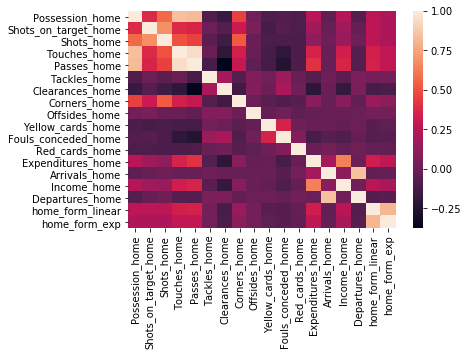

In [16]:
home_features = [ f for f in list(df_form) if 'home' in f ]
corr = df_form[home_features].corr()
_ = sns.heatmap(corr)

### Transfer Spending / Market Value

## Modeling

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split

In [18]:
clfs = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(),
        KNeighborsClassifier()]

In [19]:
X = df_wo.values
df_form.drop(columns = ['home_form_linear', 'away_form_linear'], inplace = True)
X_form = df_form.values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
X_train_form, X_test_form, y_train_form, y_test_form = train_test_split(X_form, y, test_size = .2, random_state = 42)

In [20]:
for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6370614035087719 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5679824561403509 



/home/thomas/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6304824561403509 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4583333333333333 



In [21]:
for clf in clfs:
    clf.fit(X_train_form, y_train_form)
    print(type(clf))
    print("score = ", clf.score(X_test_form, y_test_form), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6370614035087719 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.5844298245614035 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6239035087719298 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4583333333333333 



### Coefficient Investigation
Logistic Regression in particular provides a nice idea of the importance of our variables. Roughly, the larger coefficients suggest a higher importance of that feature. By inspection, we can potential use domain knowledge to drop collinear variables while keeping the best one. I.e. pick between `Touches` and `Passes`.

In [27]:
for i, feature in enumerate(list(df_form)):
    print(feature, ": ", clfs[0].coef_[:,i])

Possession_home :  [ 0.14165681  0.03913781 -0.16529435]
Possession_away :  [-0.16608845 -0.0367543   0.18522426]
Shots_on_target_home :  [-0.29663914 -0.17728384  0.41879074]
Shots_on_target_away :  [ 0.42333438 -0.08199724 -0.32353257]
Shots_home :  [ 0.02526343  0.00695076 -0.03123839]
Shots_away :  [-0.03739997  0.01134135  0.0240052 ]
Touches_home :  [-0.00382969  0.00540192 -0.00211509]
Touches_away :  [ 0.00619233 -0.00206959 -0.00159284]
Passes_home :  [-0.01218521 -0.01026212  0.02066639]
Passes_away :  [ 0.01184387  0.00453612 -0.01711467]
Tackles_home :  [-0.01441124  0.01419972 -0.00599974]
Tackles_away :  [ 0.02165046 -0.01563825 -0.00058829]
Clearances_home :  [-0.04517194 -0.00757255  0.04307041]
Clearances_away :  [ 0.03666298  0.0079024  -0.0468107 ]
Corners_home :  [-0.01793244  0.00872855  0.01395545]
Corners_away :  [ 0.03227502  0.02182631 -0.04918645]
Offsides_home :  [-0.06999692 -0.02353163  0.07938833]
Offsides_away :  [ 0.00912109  0.01505272 -0.02867386]
Yell

### Reduction of Feature Set
What if we drop some variables that are pretty collinear, or even proxies for one another. Perhaps then our models would perform better.

Based on the above, it would appear dropping shots in lieu of shots on target would be beneficial. This is perhaps unsurprising given we could take lots of bad shots, so in a sense we care about the quality of a shot, not just whether it happened. Similarly, possession seems to be more important than touches and passes. It stands to reason that most of the informational content of the touches and passes of a team are contained with the amount of possession they had during the game. 

In [35]:
df_sub = df_form.drop(columns = ['Shots_home', 'Shots_away', 'Touches_home', 
                                 'Touches_away', 'Passes_home', 'Passes_away',
                                 'Tackles_home', 'Tackles_away'])
print(list(df_sub))

['Possession_home', 'Possession_away', 'Shots_on_target_home', 'Shots_on_target_away', 'Clearances_home', 'Clearances_away', 'Corners_home', 'Corners_away', 'Offsides_home', 'Offsides_away', 'Yellow_cards_home', 'Yellow_cards_away', 'Fouls_conceded_home', 'Fouls_conceded_away', 'Red_cards_home', 'Red_cards_away', 'year', 'Expenditures_home', 'Arrivals_home', 'Income_home', 'Departures_home', 'Expenditures_away', 'Arrivals_away', 'Income_away', 'Departures_away', 'away_form_linear', 'home_form_linear', 'away_form_exp', 'home_form_exp']


Now, let's re-fit and see if we get any performance gains.

In [36]:
X_sub = df_sub.values
X_train, X_test, y_train, y_test = train_test_split(X_sub, y, test_size = .2, random_state = 42)

for clf in clfs:
    clf.fit(X_train, y_train)
    print(type(clf))
    print("score = ", clf.score(X_test, y_test), "\n")

/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/thomas/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


<class 'sklearn.linear_model.logistic.LogisticRegression'>
score =  0.6293859649122807 

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
score =  0.581140350877193 

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
score =  0.6381578947368421 

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
score =  0.4868421052631579 



Seems pretty sticky. 

In [37]:
for i, feature in enumerate(list(df_sub)):
    print(feature, ": ", clfs[0].coef_[:,i])

Possession_home :  [ 0.01027899 -0.0021698  -0.00896358]
Possession_away :  [-0.00241754 -0.01276122  0.01496017]
Shots_on_target_home :  [-0.27836046 -0.16519718  0.37838658]
Shots_on_target_away :  [ 0.40019403 -0.0655683  -0.31355547]
Clearances_home :  [-0.05261034  0.00028466  0.0426132 ]
Clearances_away :  [ 0.04385201  0.01069309 -0.05287397]
Corners_home :  [ 0.01604288  0.03042822 -0.03323567]
Corners_away :  [-0.01340102  0.02608985 -0.00778045]
Offsides_home :  [-0.07965988 -0.0116735   0.07989786]
Offsides_away :  [ 0.01481195  0.01067525 -0.02325022]
Yellow_cards_home :  [ 0.07861803  0.06310128 -0.10217843]
Yellow_cards_away :  [-0.04985651  0.04938738 -0.00362536]
Fouls_conceded_home :  [-0.0095618   0.00992163 -0.00337597]
Fouls_conceded_away :  [-0.03048352  0.01357684  0.0091956 ]
Red_cards_home :  [ 1.04814394 -0.03379634 -0.92706497]
Red_cards_away :  [-0.76095026  0.00883074  0.52558471]
year :  [-7.85822876e-04 -4.24094973e-05 -2.53833207e-04]
Expenditures_home : 

Our gains are pretty minimal here.